## [Interpolate](https://easy.gems.dkrz.de/Processing/healpix/regridding.html) to GridSat grid from Healpix level 10

In [4]:
### Import Packages: so many, gathered here 

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## HEALPix Specific
import healpy as hp
import healpix
import easygems.healpix as egh
import easygems.remap as egr

import uxarray as ux 

import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean

# Package for interpolation routine: (Could use XESMF)
from scipy.interpolate import griddata

In [5]:
import intake
# catalogue from which node? 
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["NCAR"]

In [58]:
#list(cat)

In [35]:
ds = cat.wrf_samerica(zoom=10).to_dask()
ds

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 1TB
Dimensions:   (cell: 1578037, Time: 8784)
Coordinates:
  * cell      (cell) int64 13MB 3145728 3145729 3145730 ... 12582910 12582911
    crs       float32 4B nan
  * Time      (Time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
Data variables: (12/22)
    LANDMASK  (cell) float32 6MB dask.array<chunksize=(262144,), meta=np.ndarray>
    clivi     (Time, cell) float32 55GB dask.array<chunksize=(48, 262144), meta=np.ndarray>
    clwvi     (Time, cell) float32 55GB dask.array<chunksize=(48, 262144), meta=np.ndarray>
    hflsd     (Time, cell) float32 55GB dask.array<chunksize=(48, 262144), meta=np.ndarray>
    huss      (Time, cell) float32 55GB dask.array<chunksize=(48, 262144), meta=np.ndarray>
    pr        (Time, cell) float32 55GB dask.array<chunksize=(48, 262144), meta=np.ndarray>
    ...        ...
    rsutcs    (Time, cell) float32 55GB dask.array<chunksize=(48, 262144), meta=np.ndarray>
    sncvfa    (Time, cell) float32 55GB dask.array<chunksize=(48, 262144), meta=np.ndarray>
    swe       (Time, cell) float32 55GB dask.array<chunksize=(48, 262144), meta=np.ndarray>
    tas       (Time, cell) float32 55GB dask.array<chunksize=(48, 262144), meta=np.ndarray>
    uas       (Time, cell) float32 55GB dask.array<chunksize=(48, 262144), meta=np.ndarray>
    vas       (Time, cell) float32 55GB dask.array<chunksize=(48, 262144), meta=np.ndarray>
Attributes:
    FieldType:      104
    MemoryOrder:    XY 
    cell_methods:   Time: mean
    description:    LAND MASK (1 FOR LAND, 0 FOR WATER)
    domain_extent:  (np.float32(-98.46912), np.float32(-17.530884), np.float3...
    grid_mapping:   healpix_nested
    healpix_nside:  1024
    regrid_method:  easygems_delaunay
    stagger:        
    units:

In [36]:
olr = ds.rlut
olr

<xarray.DataArray 'rlut' (Time: 8784, cell: 1578037)> Size: 55GB
dask.array<getitem, shape=(8784, 1578037), dtype=float32, chunksize=(48, 262144), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 13MB 3145728 3145729 3145730 ... 12582910 12582911
    crs      float32 4B nan
  * Time     (Time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
Attributes:
    QuantizeGranularBitGroomNumberOfSignificantDigits:  5
    description:                                        TOA OUTGOING LONG WAVE
    domain_extent:                                      (np.float32(-98.46912...
    grid_mapping:                                       healpix_nested
    healpix_nside:                                      1024
    quantization:                                       quantization_info
    quantization_nsd:                                   5
    regrid_method:                                      easygems_delaunay
    stagger:                                            
    units:                                              W m-2

<Figure size 640x480 with 0 Axes>

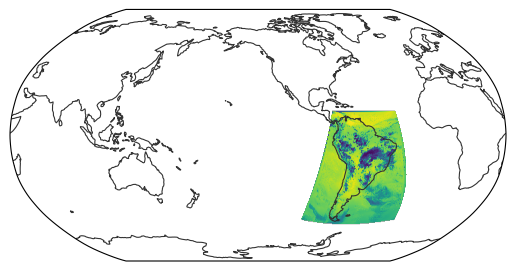

In [57]:
egh.healpix_show( olr[0] )

In [51]:
# Find the HEALPix pixels that are closest to a set of lat-lon grid points.
lon = np.arange(-75, -40, 0.07)
lat = np.arange(0, 20, 0.07) # NEGATIVE latitudes!

pix = xr.DataArray(
    hp.ang2pix(olr.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(("lat", lat), ("lon", lon)),
)
pix.max().values

array(8220810)

In [52]:
olr.isel(cell=pix)

IndexError: index 7759462 is out of bounds for axis 0 with size 1578037

In [42]:
# Suvy packages: 
import healpix_selection as hs
from healpix_selection import (
    add_latlon_coords,
    select_at_latitude,
    select_at_longitude,
    select_at_points,
    select_region,
    interpolate_to_grid,
    plot_healpix_selection,
    get_value_at_latlon
)

In [53]:
ds_with_coords = hs.add_latlon_coords(olr.to_dataset())

/glade/u/home/mapes/healpix_selection.py:71: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  pixel_indices = np.arange(ds.dims['cell'])


In [55]:
ds_with_coords.lon.max()

<xarray.DataArray 'lon' ()> Size: 8B
array(179.95605469)
Coordinates:
    crs      float32 4B nan

In [ ]:
# Brian IR cell finder 
# TEST IMAGE and "cells" (minima)

IRTHRESHOLD = 273-40 

image = ds.irwin_cdr[4]
minima = find_local_minima( smooth_array(image, sigma=1) )
coldminima = minima & (image.values < IRTHRESHOLD)
cells = np.where(coldminima) # tuple of locations, y in [0] and x in [1] oddly

# Slice lat to -20,15
image.sel(lat=slice(-20,0),lon=slice(-80,-40)).plot(cmap='Greys', size=5, aspect=1.6)
plt.scatter( ds.lon[cells[1]] , ds.lat[cells[0]], c='red', alpha=0.5, s=4 );
coastline()